# **Project: Train Coach Detection and Splitting**
## . Project Objective
The objective of this project is to design and implement an automated video processing system capable of analyzing side-view footage of a moving train, accurately detecting and counting the number of coaches. The system will automatically segment the video into individual coach clips and generate a structured summary report for each detected coach, streamlining the analysis and documentation process.

## . Final Achievements & Deliverables
- The finalized and optimized video processing pipeline successfully met all defined objectives:
- Accurate Coach Count: The system analyzed the side-view video and correctly identified 21 valid train coaches.
- Structured Output: Generated a well-organized directory structure, with sequentially numbered folders for each detected coach.
- Individual Assets per Coach: Each folder includes the corresponding split video segment in .mp4 format and a representative middle-frame image in .jpg format.
- Comprehensive Summary Report: Automatically produced a PDF report compiling the representative images for easy reference and review.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Imports & Setup

In [11]:
!pip install fpdf2

In [12]:
import cv2
import os
import shutil
import subprocess

# --- Configuration ---
INPUT_VIDEO_PATH = 'raw_train_video.mp4.mp4'   # The name of your raw input video
OUTPUT_DIR = 'Processed_Video'          # The main folder for all output
TRAIN_NUMBER = '12309'                  # The train number for naming files/folders

# --- Initial Setup ---
# Clean up previous runs by deleting the output directory if it exists
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)

# Create the main output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"✅ Setup complete. Output will be saved in the '{OUTPUT_DIR}' directory.")

✅ Setup complete. Output will be saved in the 'Processed_Video' directory.


# Video Loading and Properties

In [13]:
cap = cv2.VideoCapture(INPUT_VIDEO_PATH)

# Check if the video opened successfully
if not cap.isOpened():
    print(f"❌ Error: Could not open video file at {INPUT_VIDEO_PATH}")
    exit()

# Get video properties
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"📹 Video loaded successfully: {frame_width}x{frame_height} @ {fps} FPS, Total Frames: {total_frames}")

# --- Gap Detection Parameters ---
# The horizontal position (x-coordinate) to scan for the gap. We'll check the middle of the frame.
GAP_SCAN_X = frame_width // 2

# The brightness threshold. If the average color in our scan area is below this, it's considered a "gap".
GAP_THRESHOLD = 90

# How many consecutive frames must be "dark" to confirm it's a real gap.
# This prevents flickers from being detected as gaps.
GAP_FRAME_BUFFER = 5

# A real coach must be at least 1 second long.
MIN_COACH_DURATION_SEC = 1.0

📹 Video loaded successfully: 1920x864 @ 24 FPS, Total Frames: 2204


# Helper Function

In [14]:
def process_coach_segment(valid_coach_index, start_f, end_f):
    """
    Processes a coach segment using a sequential index for naming.
    Returns True if successful, False otherwise.
    """
    duration_sec = (end_f - start_f) / fps
    if duration_sec < MIN_COACH_DURATION_SEC:
        return False

    # Use the valid_coach_index for all naming to ensure sequential output
    coach_folder = os.path.join(OUTPUT_DIR, f"{TRAIN_NUMBER}_{valid_coach_index}")
    output_video_path = os.path.join(coach_folder, f"{TRAIN_NUMBER}_{valid_coach_index}.mp4")
    os.makedirs(coach_folder, exist_ok=True)

    print(f"      -> Processing files for Coach #{valid_coach_index}...")

    start_time = start_f / fps
    end_time = end_f / fps

    ffmpeg_command = [
        'ffmpeg', '-i', INPUT_VIDEO_PATH, '-ss', str(start_time),
        '-to', str(end_time), output_video_path, '-y', '-loglevel', 'quiet'
    ]
    subprocess.run(ffmpeg_command)

    segment_cap = cv2.VideoCapture(output_video_path)
    if not segment_cap.isOpened(): return False

    frames = [f for ret, f in iter(lambda: segment_cap.read(), (False, None))]
    segment_cap.release()

    if frames:
        # Save beginning, middle, and end frames
        beginning_frame = frames[0]
        middle_frame = frames[len(frames) // 2]
        end_frame_img = frames[-1]

        cv2.imwrite(os.path.join(coach_folder, f"{TRAIN_NUMBER}_{valid_coach_index}_beginning.jpg"), beginning_frame)
        cv2.imwrite(os.path.join(coach_folder, f"{TRAIN_NUMBER}_{valid_coach_index}_middle.jpg"), middle_frame)
        cv2.imwrite(os.path.join(coach_folder, f"{TRAIN_NUMBER}_{valid_coach_index}_end.jpg"), end_frame_img)

        print(f"      -> Saved beginning, middle, and end frames for Coach #{valid_coach_index}")
        return True # Signal success
    return False # Signal failure

# Plotting and Main Processing


PASS 1: Analyzing video to generate brightness plot...
Displaying diagnostic plot. Close the plot window to continue.


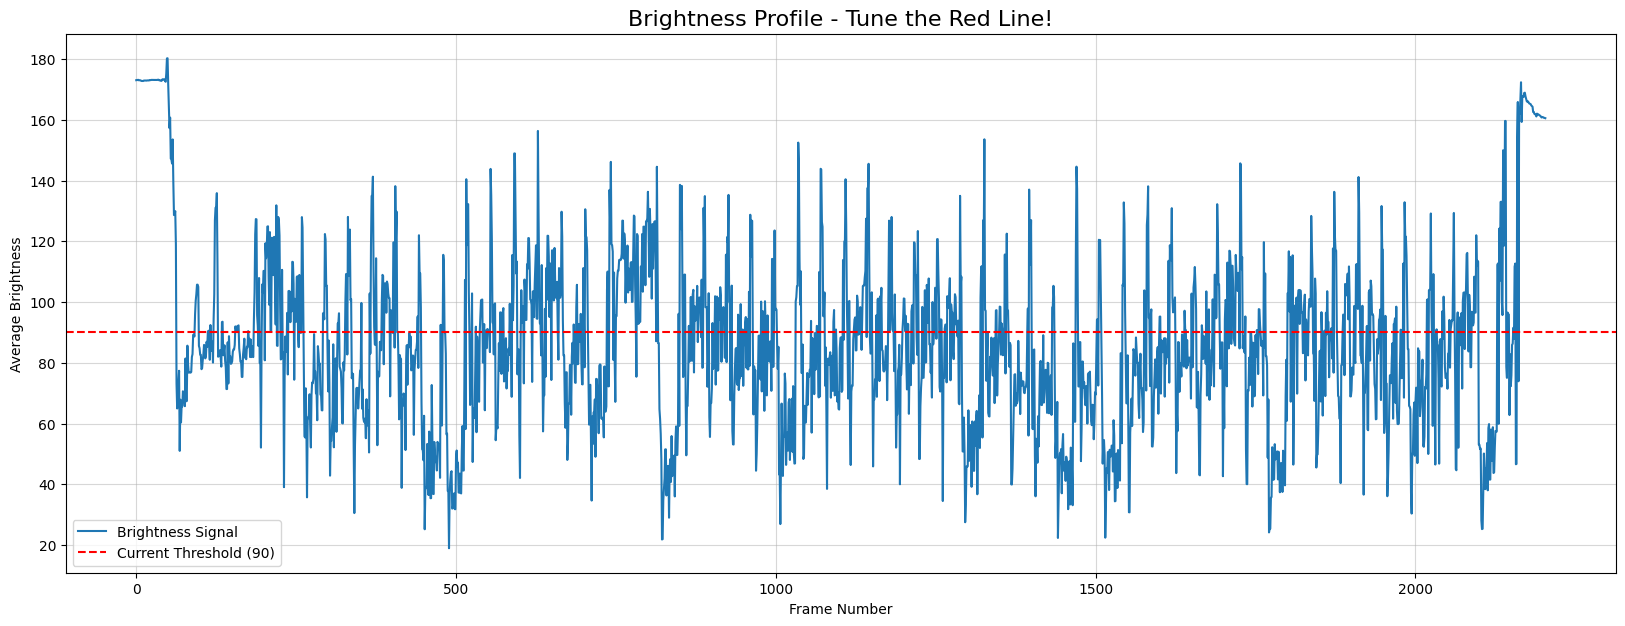


PASS 2: Processing coaches based on the threshold...
  -> Detected start of coach #1 at frame 0
  -> Detected end of coach #1 at frame 62
      -> Processing files for Coach #1...
      -> Saved beginning, middle, and end frames for Coach #1
  -> Detected start of coach #2 at frame 92
  -> Detected end of coach #2 at frame 97
  -> Detected start of coach #3 at frame 112
  -> Detected end of coach #3 at frame 127
  -> Detected start of coach #4 at frame 134
  -> Detected end of coach #4 at frame 135
  -> Detected start of coach #5 at frame 155
  -> Detected end of coach #5 at frame 160
  -> Detected start of coach #6 at frame 175
  -> Detected end of coach #6 at frame 175
  -> Detected start of coach #7 at frame 184
  -> Detected end of coach #7 at frame 228
      -> Processing files for Coach #2...
      -> Saved beginning, middle, and end frames for Coach #2
  -> Detected start of coach #8 at frame 236
  -> Detected end of coach #8 at frame 261
      -> Processing files for Coach #3.

In [15]:
import matplotlib.pyplot as plt

# --- Pass 1: Analyze Brightness and Create Plot ---
print("\nPASS 1: Analyzing video to generate brightness plot...")
brightness_signal = []
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
while True:
    ret, frame = cap.read()
    if not ret: break
    scan_line = frame[:, GAP_SCAN_X:GAP_SCAN_X + 1]
    avg_brightness = cv2.mean(scan_line)[0]
    brightness_signal.append(avg_brightness)

print("Displaying diagnostic plot. Close the plot window to continue.")
plt.figure(figsize=(20, 7))
plt.plot(brightness_signal, label='Brightness Signal')
plt.axhline(y=GAP_THRESHOLD, color='r', linestyle='--', label=f'Current Threshold ({GAP_THRESHOLD})')
plt.title('Brightness Profile - Tune the Red Line!', fontsize=16)
plt.xlabel('Frame Number')
plt.ylabel('Average Brightness')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

# --- Pass 2: Main Processing Loop ---
print("\nPASS 2: Processing coaches based on the threshold...")
coach_count = 0      # Counts all detected coaches
final_coach_count = 0 # Only counts VALID coaches
start_frame = 0
in_gap = True
gap_frames_detected = 0

for frame_number, avg_brightness in enumerate(brightness_signal):
    is_bright = avg_brightness > GAP_THRESHOLD

    if in_gap:
        if is_bright:
            in_gap = False
            start_frame = frame_number
            coach_count += 1
            print(f"  -> Detected start of coach #{coach_count} at frame {start_frame}")
    else: # in_coach
        is_dark = avg_brightness < GAP_THRESHOLD
        if is_dark:
            gap_frames_detected += 1
        else:
            gap_frames_detected = 0

        if gap_frames_detected >= GAP_FRAME_BUFFER:
            end_frame = frame_number - GAP_FRAME_BUFFER
            print(f"  -> Detected end of coach #{coach_count} at frame {end_frame}")

            # We pass the NEXT valid coach number
            if process_coach_segment(final_coach_count + 1, start_frame, end_frame):
                final_coach_count += 1 # Only increment if it was successfully saved

            in_gap = True
            gap_frames_detected = 0

# Handle the last event if the video ends
if not in_gap:
    end_frame = total_frames
    print(f"  -> Video ended. Finalizing event #{coach_count} at frame {end_frame}")
    if process_coach_segment(final_coach_count + 1, start_frame, end_frame):
        final_coach_count += 1

# Print the final count
print(f"\n✅ Processing complete. Found and saved {final_coach_count} valid coaches.")
cap.release()

# PDF Report

In [16]:
from fpdf import FPDF
import glob

print("\n📄 Generating PDF report...")

class PDF(FPDF):
    def header(self):
        self.set_font('Arial', 'B', 15)
        self.cell(0, 10, 'Train Side-View Coverage Report', 0, 1, 'C')

    def footer(self):
        self.set_y(-15)
        self.set_font('Arial', 'I', 8)
        self.cell(0, 10, f'Page {self.page_no()}', 0, 0, 'C')

pdf = PDF()
pdf.add_page()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.set_font('Arial', '', 12)

# Find all the coach folders that were created
coach_folders = sorted(glob.glob(os.path.join(OUTPUT_DIR, f"{TRAIN_NUMBER}_*")), key=lambda x: int(x.split('_')[-1]))

for folder in coach_folders:
    coach_name = os.path.basename(folder)

    # Find the beginning, middle, and end frames
    beginning_frame_path = os.path.join(folder, f"{TRAIN_NUMBER}_{coach_name.split('_')[-1]}_beginning.jpg")
    middle_frame_path = os.path.join(folder, f"{TRAIN_NUMBER}_{coach_name.split('_')[-1]}_middle.jpg")
    end_frame_path = os.path.join(folder, f"{TRAIN_NUMBER}_{coach_name.split('_')[-1]}_end.jpg")

    pdf.set_font('Arial', 'B', 14)
    pdf.cell(0, 10, f"Coach: {coach_name}", 0, 1)

    # Add the images if they exist
    if os.path.exists(beginning_frame_path):
        pdf.cell(0, 10, "Beginning of the Coach:", 0, 1)
        pdf.image(beginning_frame_path, w=pdf.w - 20)
        pdf.ln(5)

    if os.path.exists(middle_frame_path):
        pdf.cell(0, 10, "Centre of the Coach:", 0, 1)
        pdf.image(middle_frame_path, w=pdf.w - 20)
        pdf.ln(5)

    if os.path.exists(end_frame_path):
        pdf.cell(0, 10, "End of the Coach:", 0, 1)
        pdf.image(end_frame_path, w=pdf.w - 20)
        pdf.ln(10) # Add a little space after the last image

report_path = os.path.join(OUTPUT_DIR, 'Train_Coverage_Report.pdf')
pdf.output(report_path)

print(f"✅ PDF report saved to '{report_path}'")


📄 Generating PDF report...
✅ PDF report saved to 'Processed_Video/Train_Coverage_Report.pdf'


/tmp/ipython-input-20699003.py:8: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  self.set_font('Arial', 'B', 15)
/tmp/ipython-input-20699003.py:9: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  self.cell(0, 10, 'Train Side-View Coverage Report', 0, 1, 'C')
/tmp/ipython-input-20699003.py:19: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font('Arial', '', 12)
/tmp/ipython-input-20699003.py:32: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font('Arial', 'B', 14)
/tmp/ipython-input-20699003.py:33: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=1 use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, f"Coach: {coach_

## Zip File

In [17]:
from google.colab import files
import shutil

print("\n📦 Creating zip file of the results for download...")

output_zip_name = 'Train_Project_Submission'

# This is the folder we want to zip up
folder_to_zip = 'Processed_Video'

# Create the zip file in Colab's temporary storage
shutil.make_archive(output_zip_name, 'zip', folder_to_zip)

print(f"  -> Successfully created '{output_zip_name}.zip'")
print("  -> Starting download...")

# Trigger the download of the zip file to local machine
files.download(f'{output_zip_name}.zip')


📦 Creating zip file of the results for download...
  -> Successfully created 'Train_Project_Submission.zip'
  -> Starting download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Adjust the GAP_THRESHOLD based on the brightness plot
GAP_THRESHOLD = 70 # <--- Adjust this value

# Rerun the processing cell (the one after the plot) after adjusting the threshold.